# Reinforcement Learning

In reinforcement learning, a software *agent* makes *observations* and takes *actions* within an *environment*, and in return receives *rewards* from the environment. The objective is to learn to act in a way that will maximize its expected rewards over time.

Examples of use cases:
- Agent that is controlling a robot, observing through a set of *sensors* such as cameras and touch sensors, with action consisting of sending signals to activate motors. It can be programmed to get positive rewards whenever it approaches the target destination, and negative rewards whenever it wastes time or goes in the wrong direction.
- Controlling Ms.Pac-man, to obtain as much points
- Playing a board game with the reward to win the game
- Smart thermostat that gets positive reward when it is close to the target temperature and save energy.
- Observe stock market prices and decide how much to buy or sell every second.

Note that there may not be any positive rewards at all (only negative rewards, such as being in a maze).

Others include self-driving cars, recommender systems, placing ads on a web page, controlling where an image classification system should focus its attention.

## Policy Search

*Policy*: the algorithm a software agent uses to determine its actions.

e.g. a neural network taking observations as inputs and outputting the actions to take.

    *stochastic policy*, a policy that involves some randomness.

In the case of a robotic vacuum cleaner that can either move forward with some probability OR randomly rotate left or right with probability 1-p, there will be 2 *policy parameters*:
1. probability *p*
2. angle *r*

We could try out many different values for these parameters, and pick the combination that performs the best (this is called *policy search* aka brute-force approach). When the *policy space* is too large, finding a good set of parameters can be time consuming and resource intensive.

Another method is through *genetic algorithms*, where we can randomly create a first generation of 100 policies and try them out, then "kill" the 80 worst policies, make the 20 survivors produce 4 offspring each (where an offspring is a copy of its parents + random variations, is also called the second generation). The continue to iterate through generations this way until we find a good policy.

Another approach is to use optimization techniques by evaluating the gradients of the rewards with regard to the policy parameters, then tweaking these parameters by following the gradients toward higher rewards (also called *policy gradients*)

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tf_keras

In [3]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [4]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

In [7]:
%pip install -q -U "gymnasium[classic_control,box2d,atari]"


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Introduction to Gymnasium

Training is hard and slow in the real world, so we need a *simulated environment* for bootstrap training. Gymanisum provides a wide variety of simulated environments that we can use to traing agents, compare and or develop new RL algorithms!

In [8]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array")

CartPole is an 2D simulation in which a cart can be accelerated left or right in order to balance a pole placed on top of it (classic control task).

In [9]:
# extra code – shows the first few environments
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."]

['Acrobot-v1', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', '...']

In [10]:
# extra code – shows the specification for the CartPole-v1 environment
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

In [11]:
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

The 1D np array contains 4 floats representing
1. cart's horizontal position (0.0 = center),
2. velocity (positive means right)
3. angle of the pole (0.0 = vertical)
4. angular velocity (positive = clockwise)

In [12]:
info

{}

In [13]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

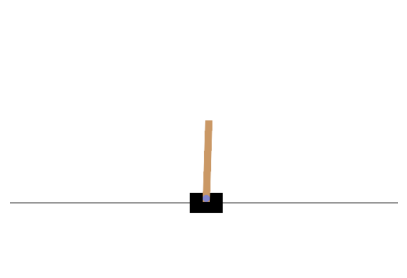

In [14]:
# extra code – creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

In [15]:
env.action_space

Discrete(2)

`Discrete(2)` means that the possible actions are integers 0 and 1, representing accelerating left or right.

In [15]:
action = 1
obs, reward, done, truncated, info = env.step(action)

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

**obs** is a new observation.<br>
Since the cart is now moving toward the right, the pole is stil tilted toward the right (`obs[2]>0`), but its angular velocity is now negative (`obs[3]<0`), so it will likely be tilted toward the left after the next step.

In [20]:
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

**reward**, we get a reward of 1.0 at every step (the goal is to keep the episode running for as long as possible)

In [16]:
reward

1.0

**done**, value will be `True` when the episode is over, and will happen when the pole tilts too much, or goes off screen, or after 200 steps

In [17]:
done

False

**truncated**, value will be `True` when an episode is interrupted early (for example by an environment wrapper that imposes a maximum number of steps per episode). Some RL algorithms treat truncated episodes differently from episodes that finished normally (**done** = `True`).

In [18]:
truncated

False

**info**, envrionment-specific dictionary that may provide extra information.

In [19]:
info

{}

In [21]:
if done or truncated:
    obs, info = env.reset()

## A simple hard-coded policy

If the pole is tilting to the left then accelerate left, if pole is tilting to the right then accelerate right.

In [22]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break
    
    totals.append(episode_rewards)

In [23]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(np.float64(41.698), np.float64(8.389445512070509), 24.0, 63.0)

In [24]:
# extra code – this cell displays an animation of one episode

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)

## Neural Network Policies

The neural network will estimate a probability for each action, and then we will select an action randomly, according to the estimated probabilities.

We pick a random action based on the probabilities to let the agent find the right balance between *exploring* new actions and *exploiting* the actions that are known to work well.

In this particular environment, the past actions can observations can safely be ignore, since each observation contains the environment' full state. If there were some hidden states, then we might need to consider past actions and observations as well (e.g. if the environment only revealed the position of the cart but not its velocity, then we would need to consider not only the current observation but also the previous observation to estimate the current velocity).

In [31]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

In [32]:
# extra code – a function that creates an animation for a given policy model

def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)[0][0]
    return int(np.random.rand() > left_proba)

np.random.seed(42)
show_one_episode(pg_policy)

2025-06-17 15:29:41.561172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


## Evaluating Actions: The Credit Assignment Problem

*credit assignment problem*, when the agent gets a reward, it is hard for it to know which actions should get credited (or blamed) for it.

To tackle this problem, we can evaluate an action based on the SUM of all the rewards that come after it, usually applying a *discount factor*, $γ$ (gamma),
at each step (also called *return*). If the discount factor is close to 0, then future rewards won't count for much compared to immediate rewards.<br>
Typical discount factors vary from 0.9 or 0.99.

While a good action my be followed by several bad actions, since we play the game enough times, on average good actions will get a higher return than bad ones. We then want to estimate how much better or worse an action is, compared to other possible actions, on average (*action advantage*). To do this, we must run many episodes and normalize all the action return, by subtracting the mean and dividing by the std. Then we can assume that actions with a negative advantage were bad 9vice versa.

## Policy Gradients

A popular PG algorithm is called *REINFORCE algorithms*, the following is 1 common variant:

1. First let the neural network policy play the game several times, and at each step, compute the gradients that would make the chosen action even more likely (but the gradients are not yet applied);
2. After 1., compute each action's advantage;
3. If an action's advantage is positive, then the action was probably good and you want to apply the gradients computed earlier to make the action even more likely to be chosen in the future. If it is negative, then we want to apply the opposite gradient to make this action slightly *less* likely in the future. Hence, multiple each gradient vector by the corresponding action's advantage
4. Compute the mean of all the resulting gradient vectors and use it to perform gradient descent step.

In [33]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1,1]) > left_proba)
        y_target = tf.constant([[1.]] - tf.cast(action, tf.float32))
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

In [34]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

In [ ]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        # count backwards
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [36]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [37]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [38]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [39]:
# extra code – let's create the neural net and reset the environment, for
#              reproducibility

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

obs, info = env.reset(seed=42)

In [40]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

In [ ]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 95/150, mean rewards: 120.7

In [ ]:
# extra code – displays the animation
np.random.seed(42)
show_one_episode(pg_policy)

The simple PG algorithm we just trained solved the CartPole task, but it would not scale well to larget and more complex tasks as it is highly *sample inefficient* as it needs to explore the game for a very long time before it can make significant progress. This is because it must run multiple episodes to estimate the advantage of each action, as we have seen.

## Markov Decision Process (MDPs)

Markov Chains inherently does not have any memory (the probability from moving from state s to s' is fixed and only depens on the pair, not on past states).

MDP resembles Markov chains, but at each step, an agent can choose one of several possible actions, and the transition probabilities depend on the chosen action. Moreover, some state transitions return some reward, and the agent's goal is to find a policy that will maximize reward over time.

*Bellman optimality equation*, where if the agent acts optimally, then the optimal value of the current state is equal to the reward it will get on average after taking one optimal action, plus the expected optimal value of all possible next states that this action can lead to.

This equation can lead directly to an algorithm that can precisely estimate the optimal state value of every possible state.
1. Initialize all the state value estimates to zero
2. Iteratively update them using the *value iteration* algorithm
3. Given enough time and iteration, the estimates are guaranteed to converge to the optimal state values, corresponding to the optimal policy.
This algorithm is an example of *dynamic programming*

A similar algorithm to estimate the optimal *state-action values* are caled Q-*values* (quality values). It is the sum of discounted future rewards the agent can expect on average after it reaches the state s and chooses action a, but before it sees the outcome of this action, assuming it acts optimally after that action.

In [ ]:
# MARKOV CHAIN
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to s0, s1, s2, s3
        [0.0, 1.0, 0.0, 0.0],  # from s2 to s0, s1, s2, s3
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to s0, s1, s2, s3

n_max_steps = 1000  # to avoid blocking in case of an infinite loop
terminal_states = [3]

def run_chain(start_state):
    current_state = start_state
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state in terminal_states:
            break
        current_state = np.random.choice(
            range(len(transition_probabilities)),
            p=transition_probabilities[current_state]
        )
    else:
        print("...", end="")

    print()

for idx in range(10):
    print(f"Run #{idx + 1}: ", end="")
    run_chain(start_state=0)

In [ ]:
# MDP

transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [  # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

### Q-value iteration

In [ ]:
Q_values = np.full((3, 3), -np.inf)  # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [ ]:
gamma = 0.90  # the discount factor

history1 = []  # extra code – needed for the figure below
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # extra code
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                for sp in range(3)])

history1 = np.array(history1)  # extra code

In [ ]:
Q_values

In [ ]:
Q_values.argmax(axis=1)  # optimal action for each state

The optimal policy for this MDP, when using a discount factor of 0.90, is to choose action a0 when in state s0, and choose action a0 when in state s1, and finally choose action a1 (the only possible action) when in state s2. If you try again with a discount factor of 0.95 instead of 0.90, you will find that the optimal action for state s1 becomes a2. This is because the discount factor is larger so the agent values the future more, and it is therefore ready to pay an immediate penalty in order to get more future rewards.

## Temporal Difference (TD) Learning

While RL problems with discrete actions can often be modeled as MDPs, the agent initially has no idea what the transition probabilities are not the rewards are going to be either. Hence it must experience each state and each transition at least once to know the rewards, and it must experience them multiple times if it is to have a reasonable estimate of the transition probabilities.

TD Learning is very similar to the Q-value iteration algorihtm, but tweaked to take into account the fact that the agent has only partial knowledge of the MDP. In general, we assume that the agent initially knows ONLY the possible states and actions. Then it uses an *exploratory policy* to explore the MDP and as it progresses, the TD learning algorithm updates the estimates of the state values based on the transitions and rewards that are actually observed.

Also like SGD, it can truly converge if we gradually reduce the learning rate!

For each states *s*, the algorithm will keep track of a running average of the immediate rewards the agent gets upon leaving that state, plus the reward it expects to get later, assuming it acts optimally.

## Q-Learning

Adaptation of Q-value iteration algorithm to the situation where the transition probabilites and rewards are initially unknown! It works by watching an agent play and gradually improving its estimates of the Q-values.

For each state-action pair (s, a), the algorithm will keep track of a running average of the rewards *r* the agents gets upon leaving the state *s* with action*a*, plus the sum of discounted future rewards it expects to get (estimated by taking the maximum of the Q-value estimates for the next state *s'*).

It is also called an *off-policy* algorithm because the policy being trained is not necessarily the one used during training. In the code below, the policy being executed (exploration policy) was completely random, while the policy being trained was never used. (PG algorithm is called *on-policy* algorithm as it explores the world using the policy being trained)

In [ ]:
# step function so the agent can execute one action and get the
# resulting state and reward
def step(state,action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0,1,2], p = probas)
    reward = rewards [state][action][next_state]
    return next_state, reward

In [ ]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [ ]:
alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.9 # discount factor
state = 0 # initial state

In [ ]:
history2 = []  # extra code – needed for the figure below

for iteration in range(10000):
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max() #greedy policy at the next step
    alpha = alpha0 / (1+iteration*decay)
    Q_values [state, action] *= 1 - alpha
    Q_values [state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)  # extra code

In [ ]:
# extra code – this cell generates and saves Figure 18–9

true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
    ax.grid(True)

save_fig("q_value_plot")
plt.show()

### Exploration Policies

While a purely random policy is guaranteed to eventually visit every state and transition many times, it may take an extremely long time to do so. Therefore, a better option is to use the  *ε-greedy policy* (ε is epsilon): at each step it acts randomly with probability ε, or greedily with probability 1–ε (i.e., choosing the action with the highest Q-value).

This policy has an advantage of spending more and more time exploring the interesting parts of the environment, as the Q-value estimates get better and better, while still spending some time visiting unknown regions of the MDP. Commonly, you start with a high value (1.0), then gradually reduce it (down to 0.05).

### Approximate Q-Learning and Deep Q-Learning

Unfortunately Q-learning does not scale well to large MDPs with many states and actions. Hence, the solution is to find a function $Q_θ$(s, a) that approximates the Q-value of any state-action pair (s, a) using a manageable number of parameters (given by the parameter vector θ). This is called *approximate Q-learning*. It was shown that using deep neural networks to do this is much better than linear combinations. A DNN used to estimate Q-values is called *deep Q-network* (DQN), and using a DQN for approximate Q-learning is called *deep Q-learning*.

Consider the approximate Q-value computed by the DQN for a given state-action pair (s,a). We know that we want the approximate Q-value to be as close as possible to the reward r (that we actually observe after playing action a in state s) + the discounted value of playing optimally from then on (estimated by executing a DQN on the next state s', for all possible actions a').

Then we pick the highest and discount it and add it to the reward r and we obtain a target Q-value y(s, a).

With the target Q-vaue, we can run a training step using any GD algorithm, and try to minimize the squared error between the estimated Q-value and the target Q-value (or the Huber loss to redue the algorithm's sensitivity to large errors).

## Implementing Deep Q-Learning

In theory, we need a neural net that takes a state-action pair as input, and outputs an approximate Q-value. However, it's much more efficient to use a neural net that takes only a state as input and outputs one approximate Q-value for each possible action.

In [ ]:
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu", input_shape = input_shape),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(n_outputs)
])

In [ ]:
def epsilon_greedy_policy (state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax() #optimal action according to the DQN

Instead of training the DQN based only on the latest experience, we store all experiences in a *replay buffer* (or *replay memory*) and sample a random training batch from it at each training iteration. This helps in reducing the correlations between the experiences in a training batch.

A *dequeue* is a queue elements that can be efficiently added to or removed from on both ends.

In [ ]:
from collections import deque

replay_buffer = deque(maxlen=2000)

In [ ]:
# extra code – A basic circular buffer implementation

class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]

And let's create a function to sample experiences from the replay buffer. It will return 6 NumPy arrays: `[obs, actions, rewards, next_obs, dones, truncateds]`.

In [ ]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

Now we can create a function that will use the DQN to play one step, and record its experience in the replay buffer:

In [ ]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

Lastly, let's create a function that will sample some experiences from the replay buffer and perform a training step:

In [ ]:
# extra code – for reproducibility, and to generate the next figure
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0

In [ ]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    # samples a batch of experiences
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    # uses the DQN to predict the Q-value for each possible action
    next_Q_values = model.predict(next_states, verbose=0)
    # keep only the maximum Q-value for each next state
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    # compute the target_Q_values
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    # masking out all the Q-values that we do not need
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        # zeroes out all the Q-values that we do not want
        # containing 1 predicted Q-value for each experience in the batch
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        # compute the loss
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    # perform a gradient descent step to minimize the loss
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    # extra code – displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)  # extra code – restores the best model weights

In [ ]:
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
save_fig("dqn_rewards_plot")
plt.show()

In [ ]:
# extra code – shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)

A problem facing virtually all RL algorithms is the *catastrophic forgetting*, where after initially stabilizing to the highest reward, the score can drop down dramatically! The analogy is that as the agent explores the environment and updates its policy, what it can learn in one part of the environment may break what it learned earlier in other parts of the environment. This can be avoided by increasing the size of the replay buffer and tuning the learning rate.

Unfortunately, in reinforcement learning, training is often unstable and we may need to try many hyperparameter values and random seeds before we find a combination that works well.

In RL, loss is a poor indicator of the model's performance since while the loss can go down, the agent might perform worse (when the agent is stuck in one small region of the environment, and the DQN starts overfitting this region). Or the loss could go up but the agent can perform better (if the DQN was underestimating the Q-values and it starts correctly increasing its predictions, the agent will likely perform better, getting more rewards, but the loss might increase be ause the DQN also sets the targets, which will be larger too).

## Deep Q-Learning Variants

### Fixed Q-value Targets

Contrary to the basic deep Q-learning algorithm (where the model is used both to make predictions and set its own targets), we use 2 DQNs
1. *online model* which learns at each step and is used to move the agent around
2. *target model* used only to define the targets.

In [ ]:
# extra code – creates the same DQN model as earlier

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

In [ ]:
target = tf.keras.models.clone_model(model)  # clone the model's architecture
target.set_weights(model.get_weights())  # copy the weights

In [ ]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

replay_buffer = deque(maxlen=2000)  # resets the replay buffer

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = target.predict(next_states, verbose=0)  # <= CHANGED
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    # extra code – displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:                        # <= CHANGED
            target.set_weights(model.get_weights())  # <= CHANGED

    # Alternatively, you can do soft updates at each step:
    #if episode > 50:
        #training_step(batch_size)
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index, online_weight in enumerate(online_weights):
        #    target_weights[index] = (0.99 * target_weights[index]
        #                             + 0.01 * online_weight)
        #target.set_weights(target_weights)

model.set_weights(best_weights)  # extra code – restores the best model weights

As the target model is updated much less often than the online model, the Q-value targets are more stable, the feedback loop between the online and target model is dampened and its effects are less severe.

In [ ]:
# extra code – this cell plots the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# extra code – shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)

### Double DQN

When estimating the Q-values, since it is an approximation, some may be slightly greater than others, by pure chance and since the target model will always select the largest Q-value, which will be slightly greater than the mean Q-value, most likely overestimating the true Q-value! To fix this, the online model is instead used to select the best actions for the next states, and using the target model only to estimate the Q-values for these best actions.

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

target = tf.keras.models.clone_model(model)  # clone the model's architecture
target.set_weights(model.get_weights())  # copy the weights

env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences

    #################### CHANGED SECTION ####################
    next_Q_values = model.predict(next_states, verbose=0)  # ≠ target.predict()
    best_next_actions = next_Q_values.argmax(axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states, verbose=0) * next_mask
                        ).sum(axis=1)
    #########################################################

    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

replay_buffer = deque(maxlen=2000)

for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

In [ ]:
# extra code – this cell plots the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# extra code – shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)

### Prioritized Experience Replay (PER)

Instead of *uniformly* sampling experiences from the replay buffer, this method sample important experiences more frequently, aka *importance sampling* (IS) or PER.

Experiences are considered "important" if they are likely to lead to fast learning progress, estimated by measure the magnitude of the TD error (opting for a large TD error value).

Since the samples will be biased toward important experiences, we must compensate for this bias during training by **downweighting** the experiences according to their importance ,else the model will overfit the important experiences.

### Dueling DQN

Note that Q(s,a) = V(s) + A(s,a)
- Q(s,a) = Q-value of a state-action pair (s,a)
- V(s) = value of state s = Q(s,$a^*$) [where it is the Q-value of the best action $a^*$ for that state]
- A(s, a) = advantage of taking the action a in state s = A(s,$a^*$) == 0.

In Dueling DQN, the model estimates both the value of the state and advantage of each possible action and since the best action should have an advantage of 0, the model subtracts the maximum predicted advantage from all predicted advantages.


In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_states = tf.keras.layers.Input(shape=[4])
hidden1 = tf.keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = tf.keras.layers.Dense(32, activation="elu")(hidden1)
state_values = tf.keras.layers.Dense(1)(hidden2)
raw_advantages = tf.keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - tf.reduce_max(raw_advantages, axis=1,
                                            keepdims=True)
Q_values = state_values + advantages
model = tf.keras.Model(inputs=[input_states], outputs=[Q_values])

In [ ]:
# extra code – trains the model

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-3)
loss_fn = tf.keras.losses.mean_squared_error

target = tf.keras.models.clone_model(model)  # clone the model's architecture
target.set_weights(model.get_weights())  # copy the weights

env.reset(seed=42)
replay_buffer = deque(maxlen=2000)
rewards = []
best_score = 0

for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

In [ ]:
# extra code – this cell plots the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# extra code – shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)

In [ ]:
env.close()

## Overview of Some Popular RL Algorithms

- AlphaGo: a variant of *Monte Carlo tree search* (MCTS), selecting the best move after running many simulations, repeatedly exploring the search tree starting from the current position, and spending more time on the most promising branches. When it reaches a node that it hasn't visited before, it plays randomly until the game ends, and updates its estimates for each visited node, increasing or decreasing each estimate depending on the final outcome. AlphaGo is based on the same principle, but uses a policy network to select moves, rather than playing randomly.

- Actor-critic algorithms: family of RL algorithms that combine PG with deep Q-networks. While the DQN is trained normally, the policy net learns differently (and much faster) than in regular PG: instead of estimating the value of each action by going through multiple episodes, then summing the future discounted rewards for each action, and finally normalizing them; the agent (actor) relies on the action values estimated by the DQN (critic). Like an athlete (agent) learning from a coach (DQN)

- Asynchronous advantage actor-critic (A3C): actor-critic variant where multiple agents learn in parallel and explores different copies of the environment. At regular intervals (but asynchronously), each agent pushes some weight updates to a master network, then pulls the lates weights from that network. Also, instead of estimating the Q-values, the DQN estimates the advantage of each action.

- Advantage actor-critic (A2C): variant of A3C, where the model updates are synchronous, so gradient updates are performed over larger batches.

- Soft actor-critic

- Proximal policy optimization (PPO), based on A2C but it clips the loss function to avoid excessively large weight updates

- Curiosity-based exploration, getting the agent to ignore the reward and make it extremely curious to explore the environment. The agent continuously tries to predict the outcome of its actions, and it seeks situations where the outcome does not match its predictions.

- Open-ended learning (OEL), training agents capable of endlessly learning new and interesting tasks, typically generated procedurally. (POET algorithm)

# Exercises